In [9]:
import pandas as pd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from random import sample
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import pearsonr

In [10]:
rna = pd.read_csv("../data/RNAseqData_LTRC_subset.txt", sep = "\t")
p2l_merged = pd.read_feather("../data/p2l_merged.feather")
l2p_merged = pd.read_feather("../data/l2p_merged.feather")
expr = pd.read_csv("../data/final_expr.txt", sep="\t")
panda_net = pd.read_feather("../data/panda_network.feather")

In [14]:
all_merged = pd.read_feather("../data/all_merged_full.feather")
all_merged = all_merged.drop(columns=["l2p_rank", "p2l_rank", "rank_diff", "abs_rank_diff"])
all_merged["z_score_combined"] = (all_merged["z_score_l2p"] + all_merged["z_score_p2l"]) / np.sqrt(2)

In [15]:
motif = pd.read_csv('../data/motif.txt', sep="\t", header=None)

motif["TF"] = motif[0]
motif["Gene"] = motif[1]
motif["Score"] = motif[2]
motif = motif.drop(columns=[0,1,2])

tot_combs = len(motif['TF'].unique()) * len(motif['Gene'].unique())
real_combs = len(motif["TF"])
real_combs/tot_combs

0.049632876611621135

(array([1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+01, 1.4000e+01,
        1.8000e+01, 3.6000e+01, 6.9000e+01, 1.2500e+02, 2.2500e+02,
        4.1300e+02, 6.8100e+02, 1.2780e+03, 2.3070e+03, 3.8110e+03,
        6.5420e+03, 1.1068e+04, 1.7579e+04, 2.6391e+04, 3.6840e+04,
        4.5694e+04, 4.8041e+04, 4.1446e+04, 3.0688e+04, 2.0925e+04,
        1.3099e+04, 7.9490e+03, 4.5180e+03, 2.8220e+03, 1.6340e+03,
        9.4600e+02, 5.2900e+02, 2.6700e+02, 1.7200e+02, 1.3200e+02,
        6.9000e+01, 4.5000e+01, 2.6000e+01, 1.7000e+01, 7.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([-10.82611105, -10.41291891,  -9.99972676,  -9.58653461,
         -9.17334246,  -8.76015031,  -8.34695817,  -7.93376602,
         -7.52057387,  -7.10738172,  -6.69418957,  -6.28099743,
         -5.86780528,  -5.45461313,  -5.04142098,  -4.62822883,
         -4.21503668,  -3.80184454,  -3.38865239,  -2.97546024

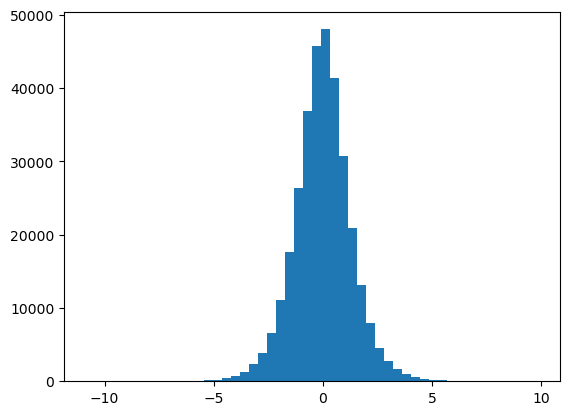

In [16]:
plt.hist(all_merged["z_score_combined"], bins=50)

In [18]:
highest_zscores = all_merged[abs(all_merged["z_score_combined"]) > 5].sort_values("z_score_combined")

In [19]:
real_edges = []

for idx, edge in highest_zscores.iterrows():
    tf = edge['TF']
    gene = edge['Gene']
    
    tf_df = motif[motif['TF'] == tf]
    
    if gene in list(tf_df['Gene']):
        real_edges.append(edge['edge'])
    
print(f"Number of total edges of interest: {highest_zscores.shape[0]}")
print(f"Number of edges of interest that actually exist in motif: {len(real_edges)}")

Number of total edges of interest: 718
Number of edges of interest that actually exist in motif: 16


In [26]:
all_merged.columns

Index(['edge', 'beta_score_l2p', 'p_value_l2p', 'beta_score_p2l',
       'p_value_p2l', 'beta_score_diff', 'p_value_diff', 'TF', 'Gene',
       'z_score_l2p', 'z_score_p2l', 'z_score_diff', 'z_score_combined'],
      dtype='object')

In [27]:
all_merged_for_analysis = all_merged[["edge", "Gene", "z_score_combined"]]

In [28]:
all_merged_for_analysis

,edge,Gene,z_score_combined
0,ALX1_MIR1-1,MIR1-1,1.287263
1,ALX1_MIR1-2,MIR1-2,1.462755
2,ALX1_MIR100,MIR100,1.324554
3,ALX1_MIR101-1,MIR101-1,1.927536
4,ALX1_MIR101-2,MIR101-2,2.624213
...,...,...,...
326452,ZZZ3_MIR95,MIR95,-0.194473
326453,ZZZ3_MIR96,MIR96,0.330478
326454,ZZZ3_MIR98,MIR98,1.165965
326455,ZZZ3_MIR99A,MIR99A,0.259350


In [ ]:
all_merged_for_analysis.to_csv("../data/all_merged_for_analysis.csv")

In [ ]:
top_20_tf = highest_zscores.value_counts("TF").head(20)

In [ ]:
top_gene = highest_zscores.value_counts("Gene")

top_gene_df = pd.DataFrame(columns=["Positive Z-Score", "Negative Z-Score", "PANDA Degree"])

for gene in top_gene.index:
    pos = sum(highest_zscores[highest_zscores["Gene"] == gene]["z_score_combined"] > 0)
    neg = sum(highest_zscores[highest_zscores["Gene"] == gene]["z_score_combined"] < 0)
    deg = sum(panda_net[gene] > 2)
    top_gene_df.loc[gene] = [pos, neg, deg]



Text(0.5, 0, 'Degree')

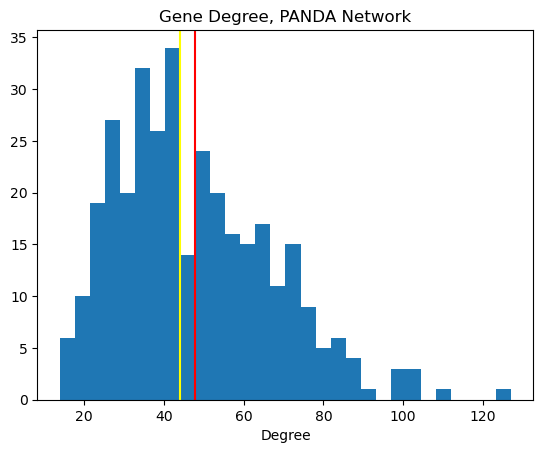

In [ ]:
degrees = []
for col in panda_net:
    degrees.append(sum(panda_net[col] > 2))
    
plt.hist(degrees, bins=30)
plt.axvline(np.median(degrees), color="yellow")
plt.axvline(np.mean(degrees), color="red")
plt.title("Gene Degree, PANDA Network")
plt.xlabel("Degree")

Text(0.5, 0, 'Degree')

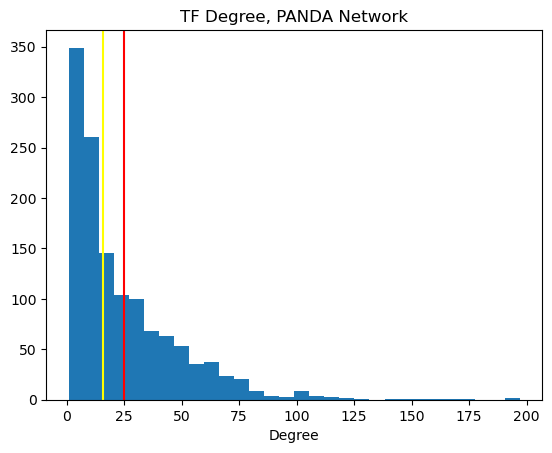

In [ ]:
degrees_tf = []
for tf in panda_net.index:
    degrees.append(sum(panda_net.loc[tf] > 2))
    
plt.hist(degrees, bins=30)
plt.axvline(np.median(degrees), color="yellow")
plt.axvline(np.mean(degrees), color="red")
plt.title("TF Degree, PANDA Network")
plt.xlabel("Degree")

In [ ]:
tf_df = pd.DataFrame(columns=["Positive Z-Score", "Negative Z-Score", "PANDA Degree"])
for tf in top_20_tf.index:
    pos = sum(highest_zscores[highest_zscores["TF"] == tf]["z_score_combined"] > 0)
    neg = sum(highest_zscores[highest_zscores["TF"] == tf]["z_score_combined"] < 0)
    deg = sum(panda_net.loc[tf] > 2)
    tf_df.loc[tf] = [pos, neg, deg]
    
tf_df

,Positive Z-Score,Negative Z-Score,PANDA Degree
DPRX,27,26,3
KLF1,23,17,2
DMBX1,16,11,3
NR5A2,9,13,2
HESX1,11,8,4
FOXB1,18,0,7
TP73,8,8,6
ZNF614,11,4,23
NANOGP8,8,5,6
HEY1,4,9,3


In [ ]:
highest_zscores.sort_values("z_score_combined").tail(20)[["edge", "beta_score_l2p", "beta_score_p2l", "z_score_combined"]]

,edge,beta_score_l2p,beta_score_p2l,z_score_combined
187535,SREBF1_MIR15A,0.442886,0.184352,7.316794
309387,ZNF764_MIR449A,0.429081,0.188687,7.328991
213638,XBP1_MIR15A,0.503385,0.168655,7.341701
100349,KLF1_MIR106A,0.484346,0.181314,7.517180
65757,GSX1_MIR941-3,0.383018,0.210245,7.538195
215256,YY1_MIR941-3,0.451609,0.191859,7.552435
26112,DPRX_MIR10B,0.619481,0.145458,7.553951
213712,XBP1_MIR30B,0.498760,0.179471,7.568164
45811,FOXB1_MIR139,0.452378,0.194228,7.613755
187797,SREBF1_MIR941-3,0.616227,0.155322,7.766835


(array([ 1.,  2.,  1.,  0.,  0.,  2.,  0.,  2.,  3.,  5.,  7.,  9.,  9.,
         6.,  4., 14., 15.,  4., 17.,  9., 13., 17., 21.,  9., 15., 20.,
        12., 22., 15., 14.,  6., 11., 15.,  7.,  6.,  4.,  2.,  2.,  3.,
         5.,  3.,  3.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([-3.76747751, -3.5900826 , -3.41268769, -3.23529279, -3.05789788,
        -2.88050297, -2.70310806, -2.52571315, -2.34831824, -2.17092333,
        -1.99352843, -1.81613352, -1.63873861, -1.4613437 , -1.28394879,
        -1.10655388, -0.92915897, -0.75176406, -0.57436916, -0.39697425,
        -0.21957934, -0.04218443,  0.13521048,  0.31260539,  0.4900003 ,
         0.6673952 ,  0.84479011,  1.02218502,  1.19957993,  1.37697484,
         1.55436975,  1.73176466,  1.90915956,  2.08655447,  2.26394938,
         2.44134429,  2.6187392 ,  2.79613411,  2.97352902,  3.15092393,
         3.32831883,  3.50571374,  3.68310865,  3.86050356,  4.03789847,
         4.21529338,  4.39268829,  4.57008319,  4.7474781 ,

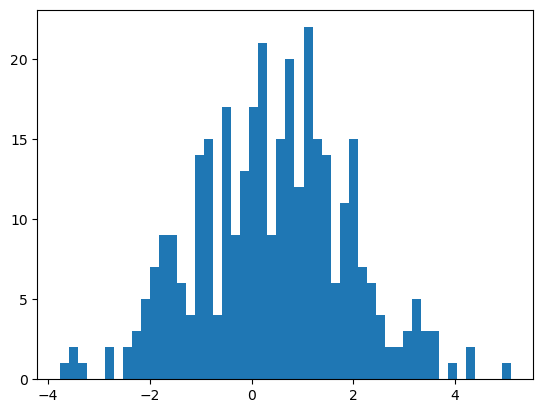

In [ ]:
plt.hist(all_merged[all_merged["TF"] == "ZNF552"]["z_score_combined"], bins=50)

In [ ]:
real_edges = highest_zscores[highest_zscores["edge"].isin(real_edges)][["edge", "beta_score_l2p", "beta_score_p2l", "z_score_combined"]]

In [ ]:
tf_df

,TF,Gene,Score,rnaseq
3789,KLF1,MIR101-1,1,NaN
3790,KLF1,MIR4485,1,NaN


In [ ]:
for index in tf_df.index:
    temp_df = rna[rna["Gene_Symbol"] == index]
    temp_df = temp_df.drop(columns=["Gene_Symbol", "ENSG"])
    mean_val = np.mean(temp_df.values)  # or temp_df.to_numpy()
    tf_df.at[index, "rnaseq"] = mean_val
    
tf_df

/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid valu

,Positive Z-Score,Negative Z-Score,PANDA Degree,rnaseq
DPRX,27,26,3,NaN
KLF1,23,17,2,NaN
DMBX1,16,11,3,NaN
NR5A2,9,13,2,1.685007
HESX1,11,8,4,0.886830
FOXB1,18,0,7,NaN
TP73,8,8,6,0.312381
ZNF614,11,4,23,2.414221
NANOGP8,8,5,6,NaN
HEY1,4,9,3,4.036618


In [ ]:
for index in gene_df.index:
    temp_df = rna[rna["Gene_Symbol"] == index]
    temp_df = temp_df.drop(columns=["Gene_Symbol", "ENSG"])
    mean_val = np.mean(temp_df.values)  # or temp_df.to_numpy()
    gene_df.at[index, "rnaseq"] = mean_val
    
gene_df

/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid valu

,Positive Z-Score,Negative Z-Score,PANDA Degree,rnaseq
MIR941-3,42,5,31,NaN
MIR15A,38,2,99,NaN
MIR664B,4,28,59,NaN
MIR139,22,9,43,NaN
MIR449B,5,22,58,NaN
MIR106A,19,2,49,NaN
MIR10B,19,0,45,NaN
MIR1270,9,7,67,NaN
MIR18B,13,3,60,NaN
MIR186,4,11,78,NaN


In [ ]:
for index in gene_df.index:
    print(index)
    print(np.mean(expr.loc[index]))
    



MIR941-3
7.234791628276101
MIR15A
8.579758587452202
MIR664B
2.1069823882527943
MIR139
8.699225992244013
MIR449B
3.288872075222261
MIR106A
2.728223722769321
MIR10B
15.020788532340003
MIR1270
1.0519424297379965
MIR18B
1.3544667634052618
MIR186
12.243955583965299
MIR144
16.867104320590176
MIR335
15.254819441684154
MIR1277
2.1763535461516232
MIR4510
1.9923495094141803
MIR128-1
5.649850778182656
MIR449A
5.292601712271867
MIR15B
12.268765338301781
MIR1226
0.8946589727875534
MIR625
4.665293590151372
MIR532
11.267809112207313


In [ ]:
np.mean(expr.loc["MIR532"])

np.float64(11.267809112207313)

In [ ]:
expr

,LT187987LL,LT166493RM,LT109321RL,LT104717LL,LT185066RL,LT291578RU,LT075094LU,LT051568RU,LT194990RU,LT132314LI,...,LT211455LU,LT174536LU,LT203541RU,LT195192RL,LT056464LL,LT271679LU,LT212777RU,LT299181LU,LT145196LU,LT167906LL
MIR15A,9.132968,8.679005,7.876751,9.057266,9.113764,9.761880,9.220851,9.104805,9.071265,9.713545,...,8.045882,8.099648,8.526389,7.745373,7.440123,6.977682,8.208773,8.158180,8.220226,7.808646
MIR16-1,12.891717,12.339001,12.077981,11.954619,11.669142,14.064280,13.346444,12.824774,11.643907,12.453548,...,12.729988,13.266475,12.448563,12.187535,12.834773,11.988119,13.661252,13.638103,13.161343,13.323901
MIR17,12.805241,12.766182,12.158283,12.464601,12.769388,13.641708,14.572626,14.196931,12.991849,13.359054,...,10.807514,11.112607,10.696812,10.065449,9.877774,9.524549,11.956913,11.626915,12.467287,10.142540
MIR18A,6.213305,5.850240,4.439106,5.526013,5.599244,7.113753,6.371074,7.114879,6.214468,7.247880,...,5.292649,5.313488,4.010424,3.762559,3.286217,3.068136,4.971829,4.963042,4.956791,2.806220
MIR19A,4.824245,4.350890,4.086025,4.841415,4.901329,5.503894,5.477987,5.551206,4.561111,4.728357,...,6.098588,8.585144,5.850551,6.775255,6.008686,6.203975,6.817243,8.296391,8.865084,4.089972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MIR5100,2.025297,0.639683,0.163129,0.442981,0.253505,0.856474,0.590379,0.608196,0.351276,0.895846,...,1.416983,1.342232,0.595341,0.363310,1.381915,0.811881,0.381196,0.777014,1.416714,1.784585
MIR664B,4.335244,4.048544,4.500448,3.400276,2.495583,4.540618,5.080015,3.509736,3.342999,4.298906,...,0.778905,0.000000,0.328164,1.789240,2.701625,1.274195,1.143840,1.975567,1.416714,2.632966
MIR548AW,1.941275,1.385134,0.780962,1.212779,1.189456,1.880193,1.711667,3.698794,2.083841,1.067251,...,1.281939,1.723842,1.187181,1.442673,0.000000,0.811881,0.000000,0.777014,1.416714,0.000000
MIR5683,3.731512,2.575284,2.956756,1.712052,2.092783,2.319238,3.530481,3.309464,1.207594,1.840806,...,1.416983,3.239533,1.015540,1.587180,2.992759,2.007912,1.328897,1.279270,0.000000,0.626090


In [ ]:
expr_list = []
for index in expr.index:
    mean_val = np.mean(expr.loc[index])
    expr_list.append(mean_val)
    

Text(0.5, 1.0, 'Average miRNA Expression, per miRNA')

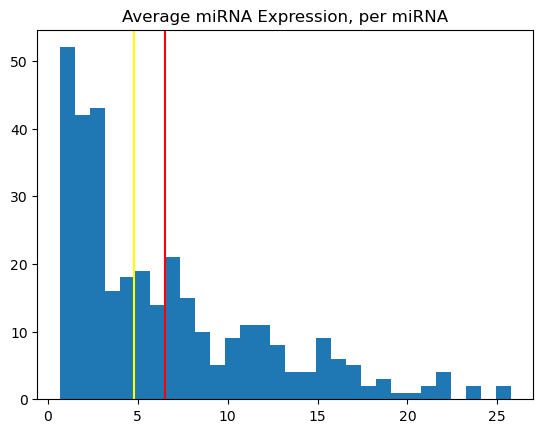

In [ ]:
plt.hist(expr_list, bins=30)
plt.axvline(np.median(expr_list), color="yellow")
plt.axvline(np.mean(expr_list), color="red")
plt.title("Average miRNA Expression, per miRNA")

In [ ]:
gene_df = gene_df["expr"]

In [ ]:
expr_regr = pd.read_csv("../data/expr_regr_fev1fvc.csv", index_col=0)

In [ ]:
# Do I define based on degree
pos_df = top_gene_df[top_gene_df["Positive Z-Score"] > top_gene_df["Negative Z-Score"]]
neg_df = top_gene_df[top_gene_df["Positive Z-Score"] < top_gene_df["Negative Z-Score"]]

pos_df = pos_df[pos_df["Positive Z-Score"] > 5]
pos_set = pos_df.index

neg_df = neg_df[neg_df["Negative Z-Score"] > 5]
neg_set = neg_df.index

In [ ]:
expr_regr

,Estimate,Std. Error,t value,Pr(>|t|)
MIR15A,-0.229286,0.195734,-1.171417,2.427977e-01
MIR16-1,-0.519207,0.229160,-2.265698,2.451990e-02
MIR17,-0.206459,0.376339,-0.548599,5.838809e-01
MIR18A,-0.446360,0.426173,-1.047369,2.961689e-01
MIR19A,-0.465435,0.363504,-1.280411,2.018545e-01
...,...,...,...,...
MIR664B,0.037036,0.281977,0.131345,8.956320e-01
MIR548AW,-0.181090,0.198784,-0.910989,3.633765e-01
MIR5683,0.185889,0.349144,0.532414,5.950189e-01
MIR5690,-0.286536,0.149043,-1.922500,5.593569e-02


In [ ]:
pos_est = list()
other_est = list()
for i in expr_regr.iterrows():
    if i[0] in pos_set:
        pos_est.append(i[1]["Estimate"])
    else:
        other_est.append(i[1]["Estimate"])

stats.ttest_ind(pos_est, other_est)

TtestResult(statistic=np.float64(-0.781999728710466), pvalue=np.float64(0.4347621902170855), df=np.float64(338.0))

In [ ]:
pos_df

,Positive Z-Score,Negative Z-Score,PANDA Degree
MIR941-3,42,5,31
MIR15A,38,2,99
MIR139,22,9,43
MIR106A,19,2,49
MIR10B,19,0,45
MIR1270,9,7,67
MIR18B,13,3,60
MIR1277,13,1,79
MIR128-1,14,0,79
MIR15B,7,5,63


In [ ]:
neg_est = list()
other_est = list()
for i in expr_regr.iterrows():
    if i[0] in neg_set:
        neg_est.append(i[1]["Estimate"])
    else:
        other_est.append(i[1]["Estimate"])

stats.ttest_ind(neg_est, pos_est)

TtestResult(statistic=np.float64(-0.5027629146432178), pvalue=np.float64(0.6182800617214019), df=np.float64(35.0))

In [ ]:
expr_regr

,Estimate,Std. Error,t value,Pr(>|t|)
MIR15A,-0.229286,0.195734,-1.171417,2.427977e-01
MIR16-1,-0.519207,0.229160,-2.265698,2.451990e-02
MIR17,-0.206459,0.376339,-0.548599,5.838809e-01
MIR18A,-0.446360,0.426173,-1.047369,2.961689e-01
MIR19A,-0.465435,0.363504,-1.280411,2.018545e-01
...,...,...,...,...
MIR664B,0.037036,0.281977,0.131345,8.956320e-01
MIR548AW,-0.181090,0.198784,-0.910989,3.633765e-01
MIR5683,0.185889,0.349144,0.532414,5.950189e-01
MIR5690,-0.286536,0.149043,-1.922500,5.593569e-02
